# Data Immersion Task 6.6 - Analyzing Time Series Data

### Table of Contents

#### 1. Wrangling Data for Time Series Analysis

#### 2. Time-series analysis: decomposition

#### 3. Testing for stationarity
    ##### 3b. Autocorrelation testing

#### 4. Stationarizing the median home price data

In [35]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import os
import warnings
from datetime import datetime

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight')

In [2]:
# Setting my data path:

path=r'D:\Adam\Employment\Data Analysis Course\Final Data Project'

In [3]:
# Importing data:

# - Realtor.com Historical Inventory by zip
df_rh = pd.read_csv(os.path.join(path, 'Data', 'Cleaned', 'Realtor_Historical_FoodZips.csv'), index_col = False)

In [4]:
df_rh.head()

,month_date_yyyymm,postal_code,city state,median_listing_price,median_listing_price_yy,active_listing_count,active_listing_count_yy,new_listing_count,new_listing_count_yy,median_listing_price_per_square_foot,...,total_listing_count,total_listing_count_yy,quality_flag,Zip,TysonZip,state,lat,lng,county_fips,county_name
0,202303,71944,"grannis, ar",231950.0,NaN,2.0,NaN,0.0,NaN,150.0,...,2.0,NaN,0.0,71944,71944,AR,34.23922,-94.32517,5113,Polk
1,202302,71944,"grannis, ar",304900.0,NaN,1.0,NaN,0.0,NaN,157.0,...,1.0,NaN,0.0,71944,71944,AR,34.23922,-94.32517,5113,Polk
2,202301,71944,"grannis, ar",304900.0,NaN,1.0,NaN,0.0,NaN,157.0,...,1.0,0.0,0.0,71944,71944,AR,34.23922,-94.32517,5113,Polk
3,202212,71944,"grannis, ar",304900.0,1.6513,1.0,0.0,0.0,NaN,157.0,...,1.0,0.0,1.0,71944,71944,AR,34.23922,-94.32517,5113,Polk
4,202211,71944,"grannis, ar",324900.0,1.8252,1.0,0.0,0.0,-1.0,167.0,...,1.0,0.0,1.0,71944,71944,AR,34.23922,-94.32517,5113,Polk


## 1. Wrangling Data for Time Series Analysis

In [5]:
# apparently only need time variable and one other variable

df_rh = df_rh[['month_date_yyyymm', 'median_listing_price']]

In [8]:
# averaging all locations by date (maybe this is a good idea so that we don't have repeate date observations)

df_rh = df_rh.groupby('month_date_yyyymm')['median_listing_price'].mean().reset_index()

In [9]:
df_rh.head()

,month_date_yyyymm,median_listing_price
0,201607,204587.190476
1,201608,204700.638498
2,201609,202882.018779
3,201610,203835.056338
4,201611,204156.193396


In [11]:
df_rh.shape

(81, 2)

only 81 instances... maybe that's not enough to run this?  I couldn't find anything in the exercise that says it needs a minimum number of observations though.  And the only other things I could do is run all of this on different locations but still not hvae more than 81 points per location.

In [29]:
# reformatting the month_date column to work better for datetime

df_rh['datetime'] = df_rh['month_date_yyyymm'].astype(str)

df_rh['datetime'] = df_rh['datetime'].str.replace(r'(\d{4})(\d{2})$', r'\1-\2') + '-01'

In [30]:
df_rh.head()

,month_date_yyyymm,median_listing_price,datetime
0,201607,204587.190476,2016-07-01
1,201608,204700.638498,2016-08-01
2,201609,202882.018779,2016-09-01
3,201610,203835.056338,2016-10-01
4,201611,204156.193396,2016-11-01


In [38]:
# setting my datetime column as a properly formatted datetime column with the right pandas function

df_rh['datetime'] = pd.to_datetime(df_rh['datetime'])

In [39]:
# setting the datetime column as the index

df_rh_sub = df_rh.set_index('datetime')
df_rh_sub.drop(['month_date_yyyymm'], axis=1, inplace=True)
df_rh_sub.head()

,median_listing_price
datetime,
2016-07-01,204587.190476
2016-08-01,204700.638498
2016-09-01,202882.018779
2016-10-01,203835.056338
2016-11-01,204156.193396


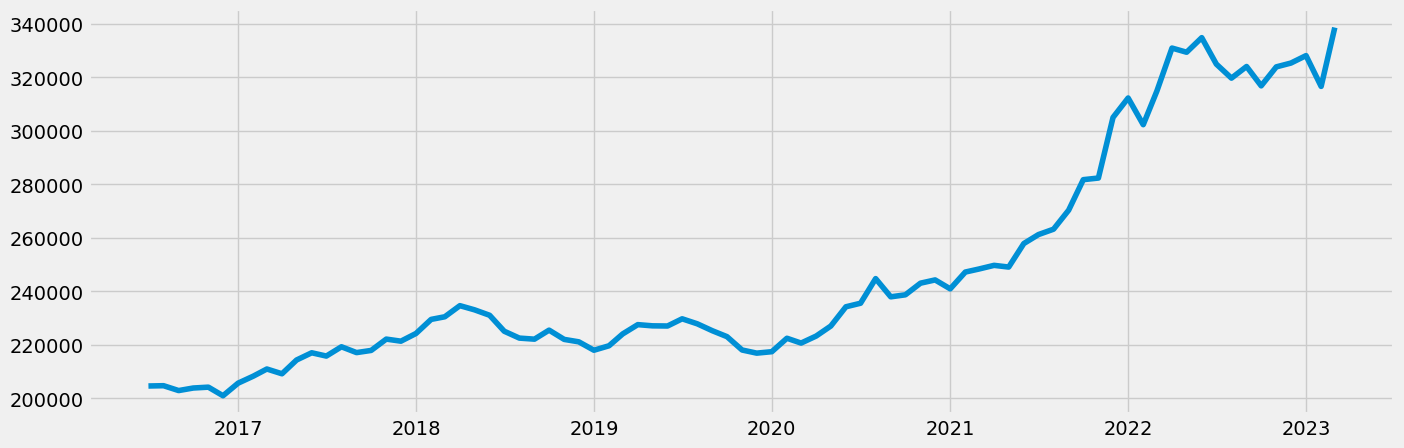

In [40]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(df_rh_sub)

In [41]:
# double-checking the data set

df_rh_sub.isnull().sum()

median_listing_price    0
dtype: int64

In [42]:
dups = df_rh_sub.duplicated()
dups.sum()

0

That's all as expected

## 2. Time-series analysis: decomposition

In [43]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_rh_sub, model='additive')

In [44]:
# Defining a fixed size for all special charts

from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

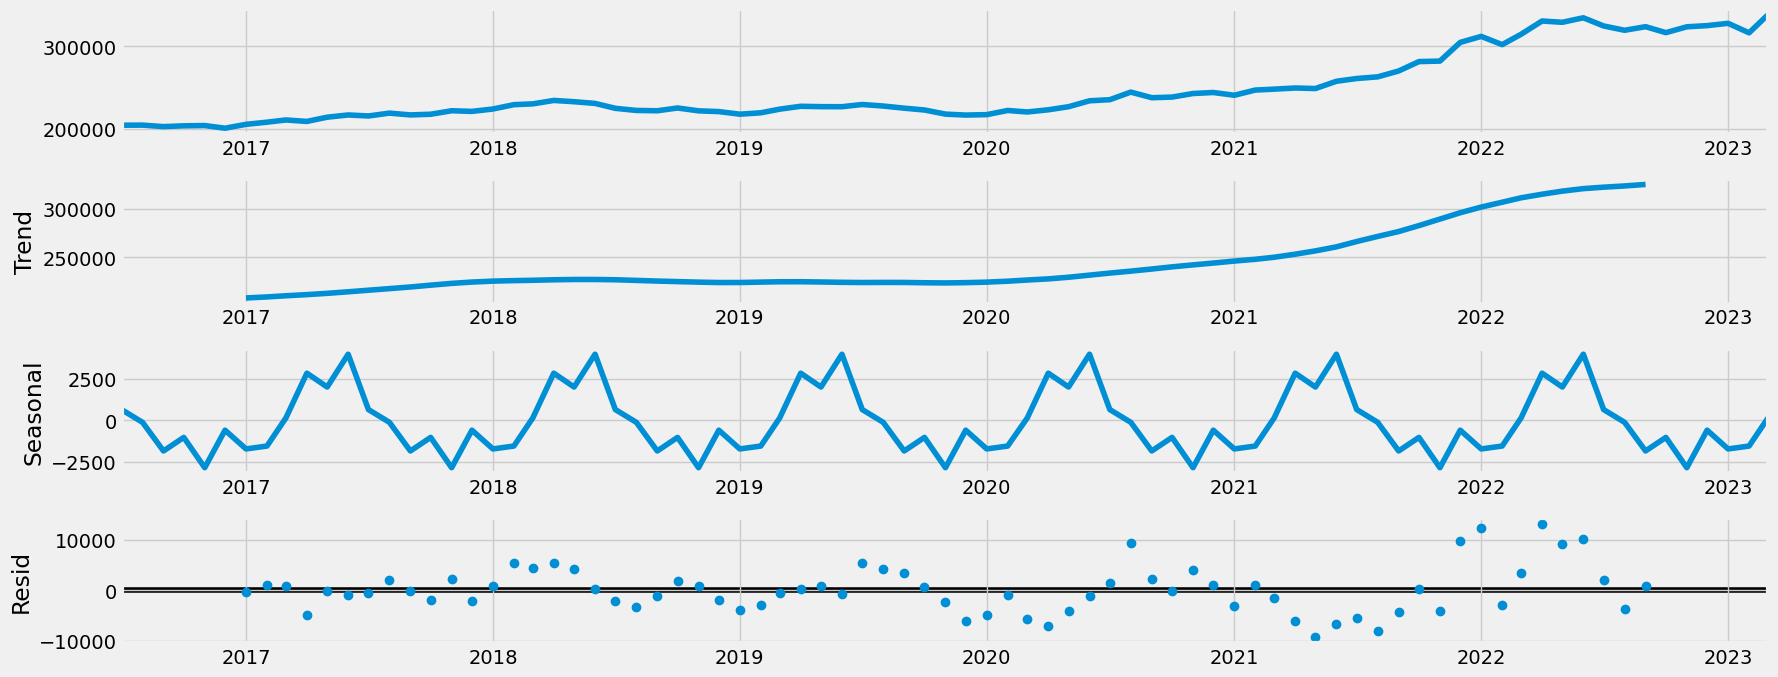

In [45]:
# Plot the separate components

decomposition.plot()
plt.show()

That's interesting.  the trend of course is obvious, but it's nice to see it smoothed out.  

The seasonal variation is totally there too, which makes a good bit of sense - peaking in late spring and early summer, then crashing in late fall and winter.  Follows standard well known market trends.  But cool to see this pull that info out so directly.  Although looking at it more closely with the more detailed chart above, it looks like they pulled the seasonality graph just from the 2022-2023 year.  Is that true or is it just more obvious that year?

The resid "noise" seems to have quite a lot, especially later one.  Makes me wonder if that's because the seasonal pattern doesn't fit as well as it looks?  Or just because I don't have enough observations for more info there?  Then again, it also makes sense that since covid the market's had a lot more noise as everything's been kinda up and down.

## 3. Testing for stationarity

In [47]:
# I honeslty don't understand this code well and it wasn't well-explained how the syntax of all of this works

from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): # Define the function

    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_rh_sub['median_listing_price'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.973845
p-value                         0.993982
Number of Lags Used             0.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


No surprise, but my test statistic is way higher than any possible critical value, so I clearly have a "unit root" and my data is obvioulsy non-stationary (as the trend line above showed)

### 3b. Autocorrelation testing

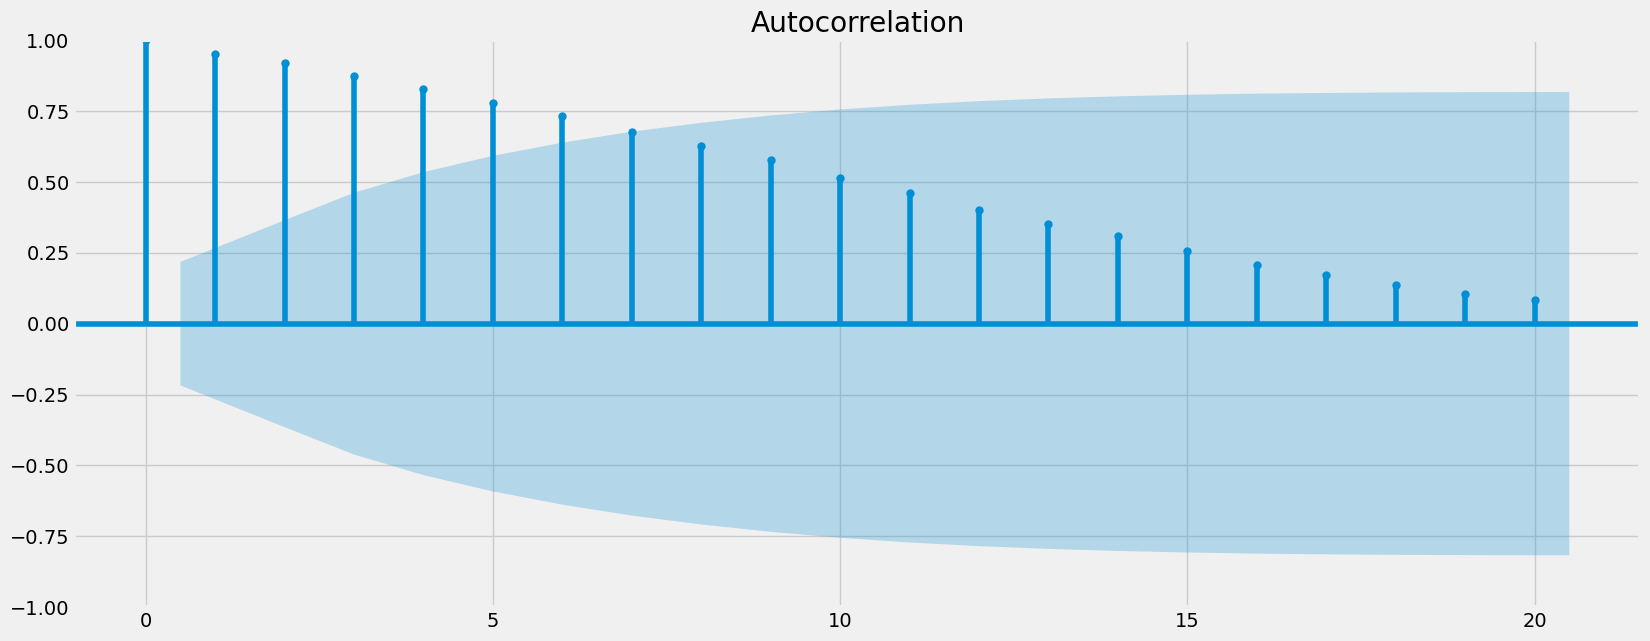

In [48]:
# Making a plot of autocorrelations

# Importing the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(df_rh_sub)
plt.show()

I only have have 7-8 lags that are above the confidence interval (significantly correlated with each other). I don't know if this is a significant amount or not, but I definitely know my data is non-stationary.

## 4. Stationarizing the median home price data

In [49]:
# Differncing my time series by subtracting the lag from each point

# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

df_diff = df_rh_sub - df_rh_sub.shift(1)

In [50]:
# Removing the missing values after differencing so I can run the Dicky-Fuller test later 

df_diff.dropna(inplace = True)

In [51]:
df_diff.head()

,median_listing_price
datetime,
2016-08-01,113.448021
2016-09-01,-1818.619718
2016-10-01,953.037559
2016-11-01,321.137058
2016-12-01,-3204.132363


still looks like a mess to me, maybe even a bigger mess

In [53]:
df_diff.columns

Index(['median_listing_price'], dtype='object')

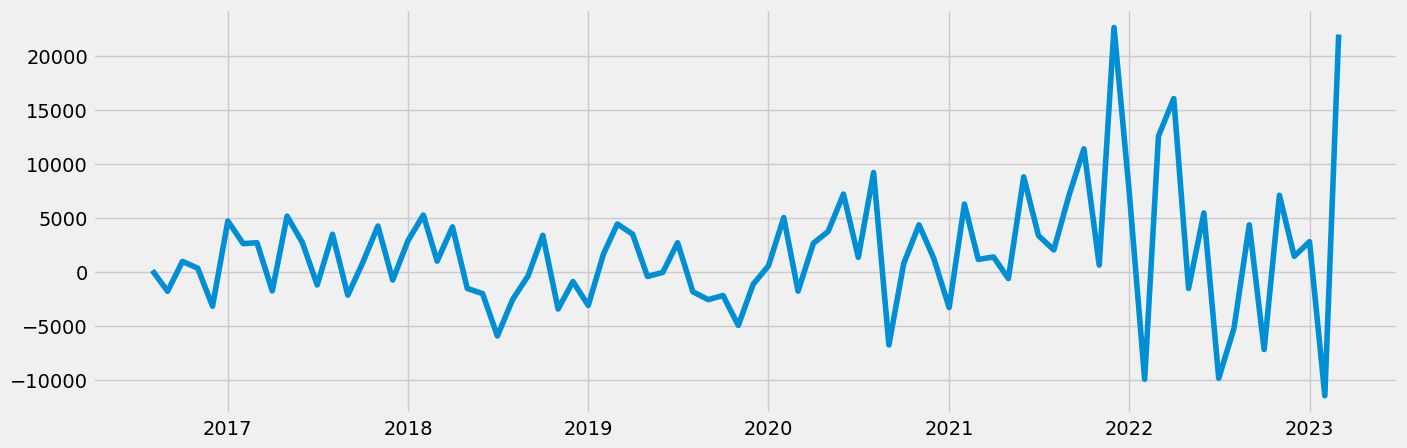

In [54]:
# curious to see what difference that's made already

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

well, I guess that's not too bad, it's basically flat along the axis it seems like

In [55]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.012203e+00
p-value                        6.083041e-15
Number of Lags Used            0.000000e+00
Number of Observations Used    7.900000e+01
Critical Value (1%)           -3.515977e+00
Critical Value (5%)           -2.898886e+00
Critical Value (10%)          -2.586694e+00
dtype: float64


wow, interesting, my test statistic is now much smaller than my critical values (even my critical value of 1%).  My p-value is also very low which shows my result is very significant.  So I guess my time-series data is now stationary

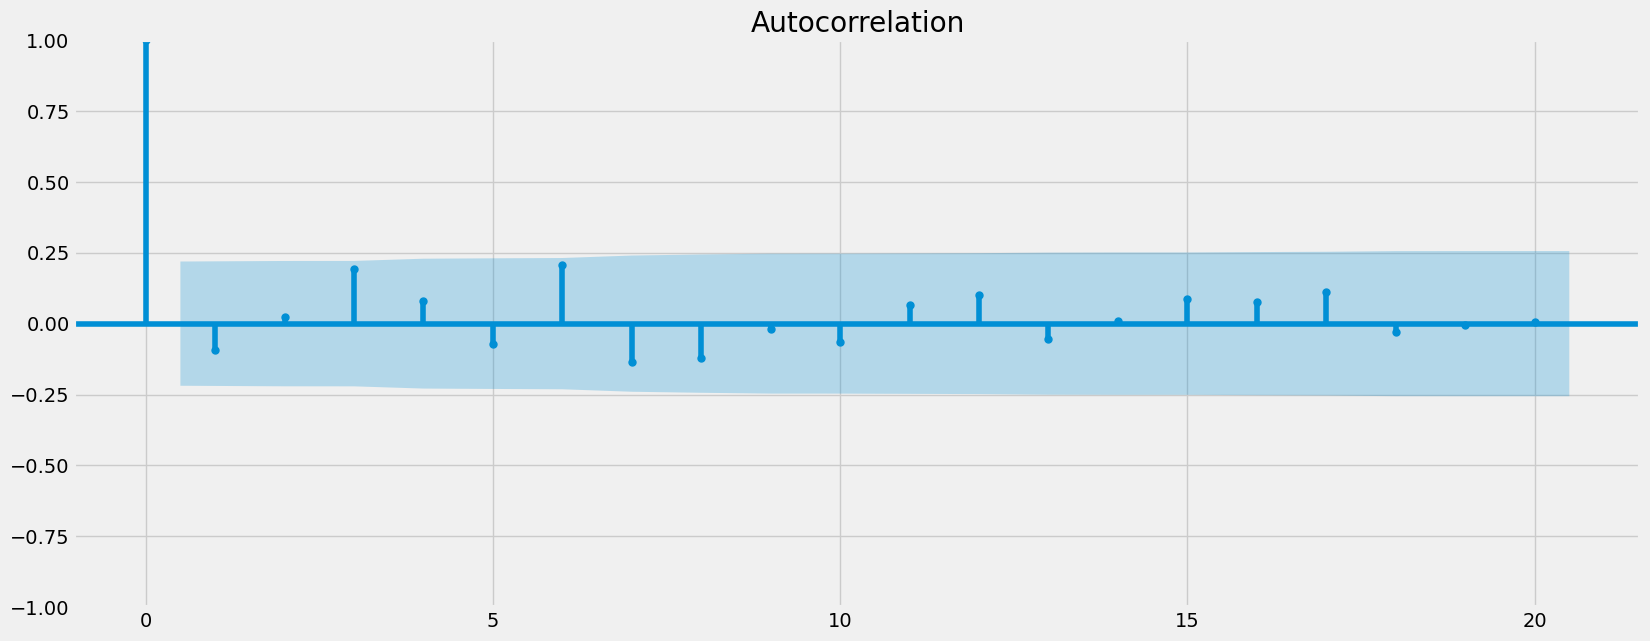

In [56]:
# checking my autocorrelations again

plot_acf(df_diff)
plt.show()

I'm not sure if that point at 0 counts, but it's the only one outside of my confidence interval.  Everything else is within the confidence interval, so I think I can confidently say my time series data is now stationary.

I would like to do the time series forecasting now that I've stationarized my data, but unfortunately I just don't have the time to learn how to do that right now.  I'll have to include it in a later version of my dashboard if I get the opportunity to do that.